In [75]:
import pandas as pd
from scipy import stats

import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

%load_ext autoreload
%autoreload 2

from funs.utils import get_merged_dataframes, chi2_independence, anova_test, spearman_correlation
from funs.plots import plot_correlation_matrix, plot_stat_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import Data and Merge DataFrames
`get_merged_dataframes` function combines multiple data sources into a single DataFrame for further analysis

In [68]:
full_data = get_merged_dataframes()

Extracting countries from coordinates...
Found 500,000 valid coordinates
Processing coordinates in batches...


100%|██████████| 500/500 [00:07<00:00, 70.92it/s]


Assigning countries to dataframe...
Countries extracted. Found 500,000 locations.


#### Basic Cleaning & Feature Engineering

In [69]:
# Missing values
full_data['education'] = full_data['education'].fillna('Missing')

# Aggregates by merchant and user
full_data['fraud_transactions_per_merchant'] = full_data.groupby('merchant_id')['is_fraud'].transform('sum')
full_data['transactions_per_merchant'] = full_data.groupby('merchant_id')['is_fraud'].transform('count')
full_data['fraud_transactions_per_user'] = full_data.groupby('user_id')['is_fraud'].transform('sum')
full_data['transactions_per_user'] = full_data.groupby('user_id')['is_fraud'].transform('count')

# Fraud ratios
full_data['fraud_ratio_per_merchant'] = (
    full_data['fraud_transactions_per_merchant'] / full_data['transactions_per_merchant']
)
full_data['fraud_ratio_per_user'] = (
    full_data['fraud_transactions_per_user'] / full_data['transactions_per_user']
)

# Timestamp -> datetime
full_data['timestamp'] = pd.to_datetime(full_data['timestamp'])
full_data['signup_date'] = pd.to_datetime(full_data['signup_date'])
full_data['hour'] = full_data['timestamp'].dt.hour
full_data['day_of_week'] = full_data['timestamp'].dt.dayofweek
full_data['days_since_signup'] = (full_data['timestamp'] - full_data['signup_date']).dt.days

# Amount avg
user_avg = full_data.groupby('user_id')['amount'].transform('mean')
full_data['amount_to_user_avg'] = full_data['amount'] / (user_avg + 1e-5)  # Avoid division by zero


# Rolling transaction count over the last 7 days
full_data = full_data.sort_values(['user_id', 'timestamp'])

def rolling_txn_count(df):
    df = df.set_index('timestamp')
    return df['transaction_id'].rolling('7d').count()

full_data['txn_count_last_7d'] = (
    full_data
    .groupby('user_id', group_keys=False)[['timestamp', 'transaction_id']]
    .apply(rolling_txn_count)
    .reset_index(drop=True)
)

full_data['is_first_ever_transaction'] = (
    full_data.groupby('user_id').cumcount() == 0
).astype(int)

# Other ratios
full_data['expense_income_ratio'] = full_data['sum_of_monthly_expenses'] / (full_data['sum_of_monthly_installments'] + 1e-5)
full_data['txn_to_expense_ratio'] = full_data['amount'] / (full_data['sum_of_monthly_expenses'] + 1e-5)

# Get transaction country counts per user
user_country_counts = full_data.groupby('user_id')['transaction_country'].nunique()

full_data['unique_countries_count'] = full_data['user_id'].map(user_country_counts)

# Transaction is in user's most frequent country
user_most_common_country = full_data.groupby('user_id')['transaction_country'].agg(lambda x: x.value_counts().index[0])
full_data['is_common_country'] = (full_data['transaction_country'] == full_data['user_id'].map(user_most_common_country)).astype(int)

# Transactions in countries user has never transacted before
user_countries = full_data.groupby('user_id')['transaction_country'].apply(set)
full_data['is_new_country'] = full_data.apply(
    lambda row: 1 if row['transaction_country'] not in user_countries.loc[row['user_id']] - {row['transaction_country']} else 0, 
    axis=1
)

#### One hot encoding

In [70]:
sex_dummies       = pd.get_dummies(full_data['sex'], prefix='sex')
education_dummies = pd.get_dummies(full_data['education'], prefix='education')
income_dummies    = pd.get_dummies(full_data['primary_source_of_income'], prefix='primary_income')
category_dummies  = pd.get_dummies(full_data['category'], prefix='category')
user_country_dummies = pd.get_dummies(full_data['user_country'], prefix='user_country')
merchant_country_dummies = pd.get_dummies(full_data['merchant_country'], prefix='merchant_country')

full_data = pd.concat([
    full_data.drop(['category', 'user_country', 'merchant_country'], axis=1),
    sex_dummies,
    education_dummies,
    income_dummies,
    category_dummies,
    user_country_dummies,
    merchant_country_dummies
], axis=1)

for col in ['channel', 'device', 'payment_method', 'education']:
    freq = full_data[col].value_counts(normalize=True)
    full_data[f'{col}_freq'] = full_data[col].map(freq)

#### Filtered correlation heatmap

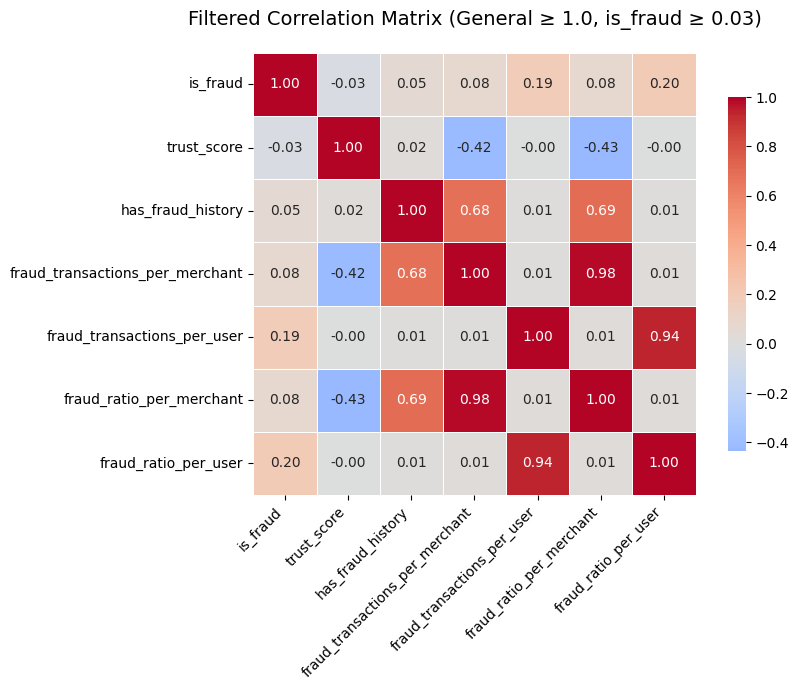

In [71]:
plot_correlation_matrix(full_data, 'is_fraud', 0.03)

#### Statictic tests
statistical tests to identify significant relationships between features and the target variable:
- **Chi-squared Test**: For categorical features.
- **ANOVA Test**: For numerical features.
- **Spearman Correlation**: For numerical features to assess monotonic relationships.


In [72]:
categorical_features = [col for col in full_data.columns if full_data[col].dtype == 'bool' 
                        or (col in ['channel', 'education', 'primary_source_of_income', 'sex'])]
numerical_features = [col for col in full_data.columns if full_data[col].dtype in ['int32', 'int64', 'float64'] 
                      and col != 'is_fraud']

chi2_positive_results = [
    chi2
    for feature in categorical_features
    if (chi2 := chi2_independence(full_data, feature, 'is_fraud')) is not None
]

anova_positive_results = [
    anova
    for feature in numerical_features
    if (anova := anova_test(full_data, feature, 'is_fraud')) is not None
]

tukey_positive_results = [
    tukey
    for feature in numerical_features
    if feature in anova_positive_results
    and (tukey := stats.tukey_hsd(full_data['is_fraud'], full_data[feature], alpha=0.05)) is not None
]


spearman_positive_results = [
    spearman
    for feature in numerical_features
    if (spearman := spearman_correlation(full_data, feature, 'is_fraud')) is not None
]

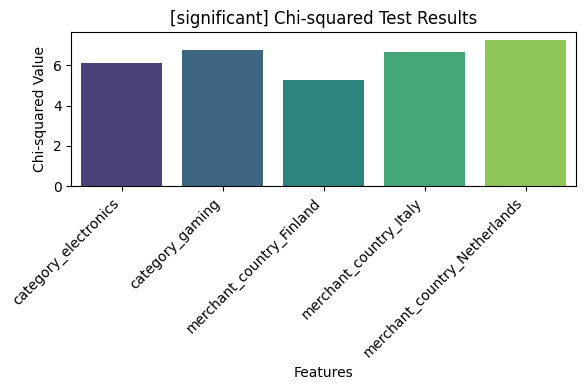

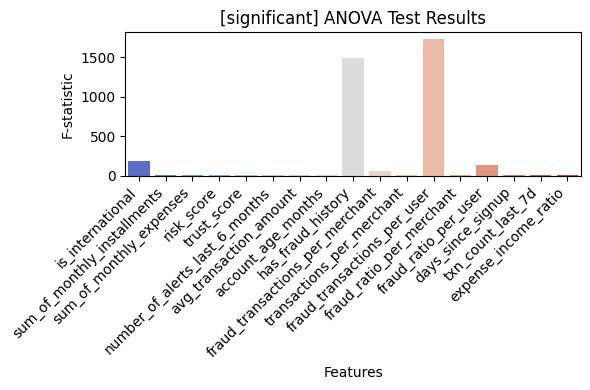

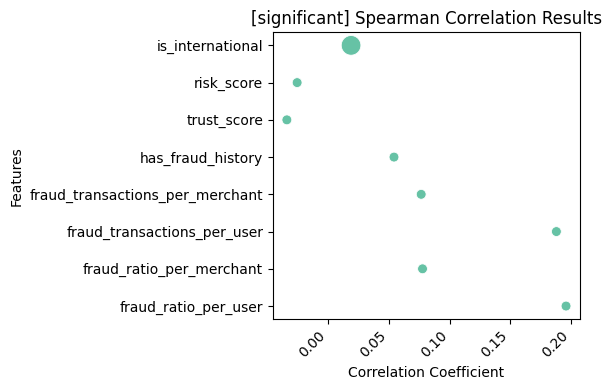

In [73]:
plot_stat_results(
    pd.DataFrame(chi2_positive_results), x_col='column', y_col='chi2', plot_type='barplot',
    title='[significant] Chi-squared Test Results', xlabel='Features', ylabel='Chi-squared Value',
    hue='column', palette='viridis', dodge=False, legend=False
)

plot_stat_results(
    pd.DataFrame(anova_positive_results), x_col='column', y_col='f_statistic', plot_type='barplot',
    title='[significant] ANOVA Test Results', xlabel='Features', ylabel='F-statistic',
    palette='coolwarm', hue='column', dodge=False, legend=False
)

plot_stat_results(
    pd.DataFrame(spearman_positive_results), x_col='correlation_coefficient', y_col='column', plot_type='scatterplot',
    title='[significant] Spearman Correlation Results', xlabel='Correlation Coefficient', ylabel='Features',
    size='p_value', hue='significant', palette='Set2', sizes=(50, 200), legend=False
)

#### Saving data

In [74]:
output_dir = os.path.join('../..', 'data', 'processed')
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'full_data.csv')

full_data.to_csv(output_file, index=False)

print(f"Data saved to {output_file}")

Data saved to ../../data/processed/full_data.csv
